In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Class Weights: {0: np.float64(0.7513297872340425), 1: np.float64(1.183659217877095), 2: np.float64(1.2649253731343284), 3: np.float64(0.9674657534246576)}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 516s 10s/step - accuracy: 0.3162 - loss: 1.6192 - val_accuracy: 0.4004 - val_loss: 1.2934
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5561 - loss: 1.1232 - val_accuracy: 0.4781 - val_loss: 1.1127
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.6415 - loss: 0.9190 - val_accuracy: 0.4562 - val_loss: 1.1201
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.7314 - loss: 0.7063 - val_accuracy: 0.4681 - val_loss: 1.1430
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.7756 - loss: 0.6342 - val_accuracy: 0.4900 - val_loss: 1.0959
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7678 - loss: 0.6222 - val_accuracy: 0.5239 - val_loss: 1.0783
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8167 - loss: 0.5107 - val_accuracy: 0.5717 - val_loss: 1.0484
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8214 - loss: 0.4944 - val_accuracy: 0.5996 - 

Model saved successfully!
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 931ms/step


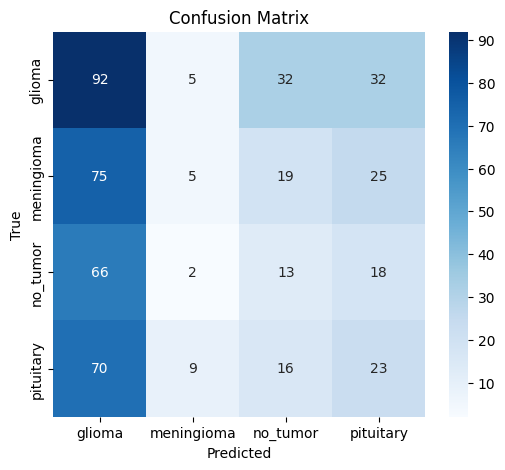

              precision    recall  f1-score   support

      glioma       0.30      0.57      0.40       161
  meningioma       0.24      0.04      0.07       124
    no_tumor       0.16      0.13      0.15        99
   pituitary       0.23      0.19      0.21       118

    accuracy                           0.26       502
   macro avg       0.23      0.23      0.21       502
weighted avg       0.24      0.26      0.22       502



In [3]:
# -----------------------------
# 1. Imports
# -----------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# -----------------------------
# 2. Paths and classes
# -----------------------------
train_dir = '/content/drive/MyDrive/Tumour/train'
val_dir = '/content/drive/MyDrive/Tumour/valid'
classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# -----------------------------
# 3. Data Augmentation
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# -----------------------------
# 4. Compute Class Weights
# -----------------------------
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(classes)),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)

# -----------------------------
# 5. Load MobileNetV2 Base Model
# -----------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# -----------------------------
# 6. Add Custom Top Layers
# -----------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# -----------------------------
# 7. Unfreeze last 50 layers for fine-tuning
# -----------------------------
for layer in base_model.layers[-50:]:
    layer.trainable = True

# -----------------------------
# 8. Compile the Model
# -----------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# 9. Train the Model
# -----------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # You can increase to 15-20 later
    class_weight=class_weights,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# -----------------------------
# 10. Save the Model
# -----------------------------
model.save('brain_tumor_mobilenetv2.h5')
print("Model saved successfully!")

# -----------------------------
# 11. Evaluation (Confusion Matrix + Report)
# -----------------------------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

val_generator.reset()
y_pred_probs = model.predict(val_generator, steps=len(val_generator), verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=classes)
print(report)


In [4]:
# -----------------------------
# 1. Imports
# -----------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras import backend as K

# -----------------------------
# 2. Paths and classes
# -----------------------------
train_dir = '/content/drive/MyDrive/Tumour/train'
val_dir = '/content/drive/MyDrive/Tumour/valid'
classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# -----------------------------
# 3. Data Augmentation with Oversampling
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Standard generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# -----------------------------
# 4. Focal Loss Definition
# -----------------------------
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# -----------------------------
# 5. Load MobileNetV2 Base Model
# -----------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Unfreeze last 100 layers
for layer in base_model.layers[:-100]:
    layer.trainable = False
for layer in base_model.layers[-100:]:
    layer.trainable = True

# -----------------------------
# 6. Add Custom Top Layers
# -----------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# -----------------------------
# 7. Compile Model with Focal Loss
# -----------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)

# -----------------------------
# 8. Train Model
# -----------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# -----------------------------
# 9. Save Model
# -----------------------------
model.save('brain_tumor_mobilenetv2_focal.h5')
print("Model saved successfully!")


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.2899 - loss: 0.3519 - val_accuracy: 0.4004 - val_loss: 0.2146
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5205 - loss: 0.1884 - val_accuracy: 0.4841 - val_loss: 0.2143
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6049 - loss: 0.1369 - val_accuracy: 0.5020 - val_loss: 0.2048
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6392 - loss: 0.1193 - val_accuracy: 0.5080 - val_loss: 0.2076
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.7329 - loss: 0.0898 - val_accuracy: 0.5339 - val_loss: 0.1968
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.7658 - loss: 0.0768 - val_accuracy: 0.5737 - val_loss: 0.1815
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7707 - loss: 0.0777 - val_accuracy: 0.5956 - val_loss: 0.1697
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.7975 - loss: 0.0616 - val_accuracy: 0.6096 - v

Model saved successfully!


16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.31      0.45      0.36       161
  meningioma       0.32      0.10      0.16       124
    no_tumor       0.22      0.19      0.20        99
   pituitary       0.20      0.24      0.22       118

    accuracy                           0.26       502
   macro avg       0.26      0.25      0.24       502
weighted avg       0.27      0.26      0.25       502



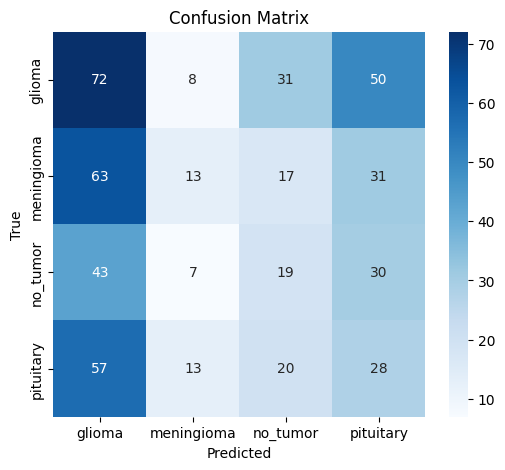

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels
y_true = val_generator.classes

# Get predictions
y_pred_probs = model.predict(val_generator, steps=len(val_generator), verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class names
class_labels = list(val_generator.class_indices.keys())

# -----------------------------
# Classification Report
# -----------------------------
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [7]:
# -----------------------------
# 1. Imports
# -----------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras import backend as K

# -----------------------------
# 2. Paths and classes
# -----------------------------
train_dir = '/content/drive/MyDrive/Tumour/train'
val_dir = '/content/drive/MyDrive/Tumour/valid'
classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# -----------------------------
# 3. Class-Specific Data Augmentation
# -----------------------------
# Aggressive augmentation for minority classes
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=[0.7,1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# -----------------------------
# 4. Compute Class Weights
# -----------------------------
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(classes)),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)

# -----------------------------
# 5. Weighted Focal Loss
# -----------------------------
def weighted_focal_loss(weights, gamma=2., alpha=.25):
    weights = tf.constant(weights, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        ce = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        weighted_ce = ce * weight * y_true * weights
        return K.sum(weighted_ce, axis=1)
    return loss

# -----------------------------
# 6. Load MobileNetV2 Base Model
# -----------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Fine-tune last 150 layers
for layer in base_model.layers[:-150]:
    layer.trainable = False
for layer in base_model.layers[-150:]:
    layer.trainable = True

# -----------------------------
# 7. Add Custom Top Layers
# -----------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# -----------------------------
# 8. Compile Model
# -----------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=weighted_focal_loss(class_weights_array, gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

# -----------------------------
# 9. Short-run Training (5-8 epochs)
# -----------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # short-run
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# -----------------------------
# 10. Save Model
# -----------------------------
model.save('brain_tumor_mobilenetv2_weighted_focal.h5')
print("Model saved successfully!")


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Class Weights: {0: np.float64(0.7513297872340425), 1: np.float64(1.183659217877095), 2: np.float64(1.2649253731343284), 3: np.float64(0.9674657534246576)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 294s 5s/step - accuracy: 0.3278 - loss: 0.4025 - val_accuracy: 0.3167 - val_loss: 0.4797
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 307s 5s/step - accuracy: 0.4889 - loss: 0.2018 - val_accuracy: 0.3247 - val_loss: 0.5659
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.5487 - loss: 0.1550 - val_accuracy: 0.3267 - val_loss: 0.5984
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.6343 - loss: 0.1284 - val_accuracy: 0.3287 - val_loss: 0.5583
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 329s 5s/step - accuracy: 0.6699 - loss: 0.1141 - val_accuracy: 0.3327 - val_loss: 0.5434


Model saved successfully!


16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
              precision    recall  f1-score   support

      glioma       0.32      0.98      0.48       161
  meningioma       1.00      0.01      0.02       124
    no_tumor       0.00      0.00      0.00        99
   pituitary       0.00      0.00      0.00       118

    accuracy                           0.32       502
   macro avg       0.33      0.25      0.12       502
weighted avg       0.35      0.32      0.16       502



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


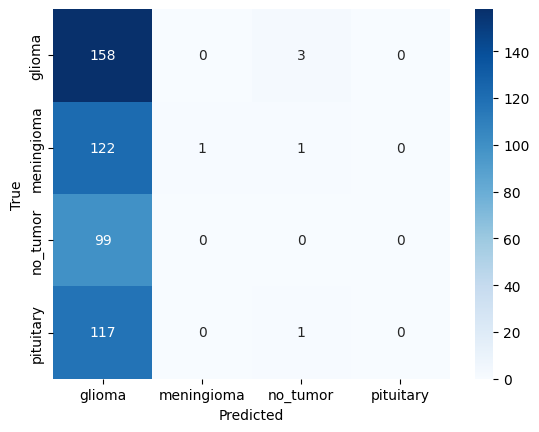

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [9]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1-y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss


In [11]:
# -----------------------------
# 1. Imports
# -----------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy as np

# -----------------------------
# 2. Paths and classes
# -----------------------------
train_dir = '/content/drive/MyDrive/Tumour/train'
val_dir = '/content/drive/MyDrive/Tumour/valid'
classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# -----------------------------
# 3. Data Augmentation
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# -----------------------------
# 4. Compute class weights
# -----------------------------
from sklearn.utils.class_weight import compute_class_weight
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(classes)),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)

# -----------------------------
# 5. Focal Loss
# -----------------------------
def focal_loss(gamma=2., alpha=.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0-K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1-y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return loss

# -----------------------------
# 6. Load MobileNetV2
# -----------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze all but last 100 layers
for layer in base_model.layers[:-100]:
    layer.trainable = False
for layer in base_model.layers[-100:]:
    layer.trainable = True

# -----------------------------
# 7. Add Custom Top Layers
# -----------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# -----------------------------
# 8. Compile Model with Focal Loss
# -----------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)

# -----------------------------
# 9. Train Model with Class Weights
# -----------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,  # Increase if GPU allows
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    class_weight=class_weights
)

# -----------------------------
# 10. Save Model
# -----------------------------
model.save('brain_tumor_mobilenetv2_focal.h5')
print("Model saved successfully!")


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Class Weights: {0: np.float64(0.7513297872340425), 1: np.float64(1.183659217877095), 2: np.float64(1.2649253731343284), 3: np.float64(0.9674657534246576)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.3086 - loss: 0.2962 - val_accuracy: 0.3227 - val_loss: 0.3581
Epoch 2/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.4862 - loss: 0.1803 - val_accuracy: 0.3327 - val_loss: 0.3830
Epoch 3/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.6260 - loss: 0.1359 - val_accuracy: 0.3486 - val_loss: 0.3859
Epoch 4/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.6692 - loss: 0.1204 - val_accuracy: 0.3606 - val_loss: 0.3763
Epoch 5/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.7060 - loss: 0.1043 - val_accuracy: 0.3665 - val_loss: 0.3577
Epoch 6/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.7498 - loss: 0.0850 - val_accuracy: 0.3865 - val_loss: 0.3414
Epoch 7/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.7459 - loss: 0.0815 - val_accuracy: 0.4104 - val_loss: 0.3073
Epoch 8/15
53/53 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.7600 - loss: 0.0841 - val_accuracy: 0.4422 - v

Model saved successfully!


16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
              precision    recall  f1-score   support

      glioma       0.36      0.61      0.45       161
  meningioma       0.25      0.04      0.07       124
    no_tumor       0.29      0.30      0.30        99
   pituitary       0.23      0.19      0.21       118

    accuracy                           0.31       502
   macro avg       0.28      0.29      0.26       502
weighted avg       0.29      0.31      0.27       502



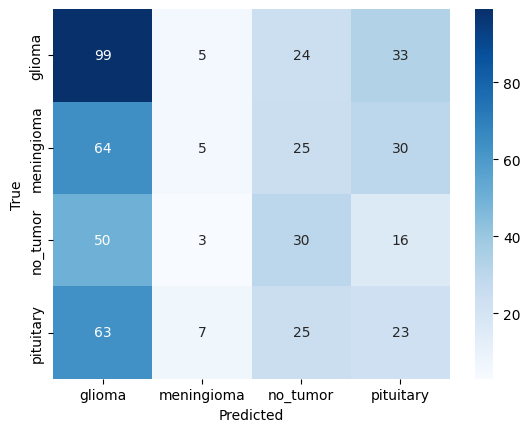

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_true = val_generator.classes
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

